In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

In [10]:
games = pd.read_csv('CSV/games_slim.csv', encoding='latin-1', index_col = False)
games_pred = pd.read_csv('CSV/games_pred.csv', encoding='latin-1', index_col = False, )
games = games.iloc[:,1:]
games_pred = games_pred.iloc[:,1:]
runs = games_pred['Runs']
games['Runs'] = runs
seed = 1

In [11]:
games.head()

,DP_SIDE_pit,FB%_SIDE_pit,GB%_SIDE_pit,LD%_SIDE_pit,AVG_SIDE_pit,OBP_SIDE_pit,TAV_SIDE_pit,R_Pitching_Std,HR_Pitching_Std,BB_Pitching_Std,...,TAV_SIDEbatter_Std,Temp,Humidity,Wind,STADIUM,Wind_Level,FB%_Level,Temp_Level,Humidity_Level,Runs
0,0.019,0.216,0.452,0.262,0.224,0.303,0.254,0.2637,0.0569,0.2251,...,0.2812,69,77,0.0,CHN,2,2,2,2,1
1,0.027,0.187,0.493,0.266,0.233,0.294,0.249,0.3029,0.0805,0.1920,...,0.3030,80,42,0.0,LAN,2,1,3,1,5
2,0.026,0.232,0.452,0.239,0.265,0.318,0.285,0.2554,0.0557,0.2003,...,0.2809,67,68,4.0,PHI,3,2,2,2,3
3,0.021,0.215,0.490,0.252,0.214,0.302,0.257,0.2332,0.0668,0.2369,...,0.2324,68,72,3.0,BAL,3,2,2,2,4
4,0.013,0.239,0.417,0.246,0.217,0.291,0.225,0.2536,0.0891,0.1822,...,0.2488,66,67,12.0,SFN,3,2,2,2,0


In [12]:
games_pred.head()

,Dates,Teams,Runs,Predict
0,10/1/2018,MIL,1,4.0
1,10/1/2018,COL,5,4.0
2,9/30/2018,ATL,3,4.0
3,9/30/2018,HOU,4,4.0
4,9/30/2018,LAN,0,4.0


This analysis is part of a larger project that seeks to determine what factors effect the number of runs scored in a game and to use them to make better predictions.  After exploritory analysis was run, certain elements of the weather showed enough potential effect to warrant further investigation. The effect of temperature, wind and humidity on the number of runs scored in mlb games are examined in this notebook.

## __Temperature__

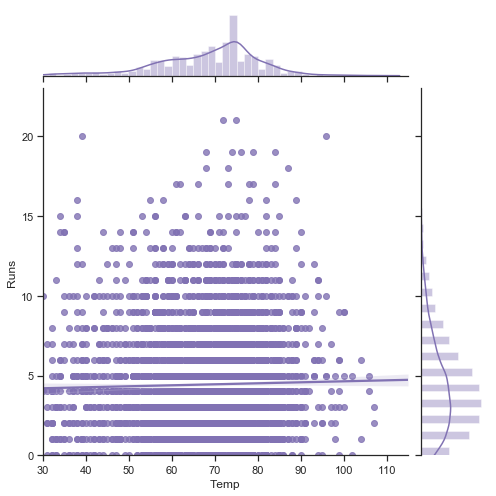

In [13]:
g = sns.jointplot('Temp', 'Runs', data=games, kind="reg",
                  xlim=(30, 115), ylim=(0, 23), color="m", height=7)

The Runs vs Temperature plot contains a regression line which shows a small increase in runs as temperature increases.  The confidence interval is wider near the extremes where less data exists.  The temperature histogram shows that a bulk of the games were played at temperatures near 75 degrees.  The runs scored histogram skews right and most of the games resulted in 3-6 runs with 4 runs/game occuring with the most frequency. 

It is normally preferable to keep continuous variables continuous in order to avoid __data leakage__. However, due to the small expected effect size, high variability and a relatively small sample size, it may be better to seperate temperature into intervals.  The variance can also be reduced by removing the outliers and limiting the range to the area with the most data.

__Two methods will be used to explore the data:__
1.  Regression Analysis
    -  the temperature variable will be kept continuous but the range of temperatures used will be reduced to eliminate temperatures with limited corresponding games.  Outliers will also be removed.
2.  Bootstrapping with Hypothesis Testing
    -  nominal variables will be created using the temperature range and outlier removed data used in regression.

Assuming a __minimum detectable effect__ of 0.2, an __alpha__ of 0.05, a __power__ of 0.8 and splitting into 10 intervals of 10 degree differences, a sample size of 23,188 (2,108 per group) is recommended to determine an effect.  There are only 4,832 games in this sample, so the sample will need to be split into a small number of ordinal intervals.  Smaller intervals do a better job of preserving the integrity of the data, but larger intervals are less likely to be biased by outliers and high variability.

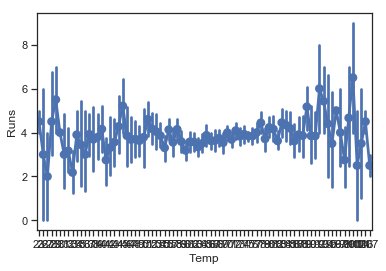

In [14]:
#sns.set()
#f, ax = plt.subplots(figsize=(14, 5))
sns.pointplot('Temp', 'Runs', data=games[games['Runs'] < 10])
#sns.despine(bottom=True)
#plt.show()

__Selecting the Temperature Range__
The Temperature vs Runs chart has small confidence intervals between 58 and 82 degrees, where the bulk of games exist. These confidence intervals increase in size at the less frequent temperatures.  The area between 58 and 82 will be used for analysis to prevent the high variance in small sample sizes from corrupting the results.  

Optimally, the data would be split into equal temperature intervals and equal sample sizes, which result in more accurate and interperatable results.  Equal intervals were used because equal sample sizes produced far too uneven temperature intervals.

__Outlier Removal__
Runs exceeding 3 standard deviations from the mean were considered outliers and removed.

__Creating the Hypotheses__

H0:  Temperature has no effect on average runs scored per baseball game
H1:  Average runs scored per baseball game increase as temperature increases

In [15]:
games = games.sort_values('Temp')
games = games.reset_index()

# Create data frame for games with temps between 58 and 81
games1 = games[(games['Temp'] >= 58) & (games['Temp'] < 82) & (games['Runs'] < 10)].copy()

t1 = games1['Runs'][(games1['Temp'] >= 58) & (games1['Temp'] < 66)]
t2 = games1['Runs'][(games1['Temp'] >= 66) & (games1['Temp'] < 74)]
t3 = games1['Runs'][(games1['Temp'] >= 74) & (games1['Temp'] < 82)]

games1['Temp_Level1'] = 0
games1.loc[games1.Temp < 66, 'Temp_Level1'] = 1
games1.loc[(games1.Temp >= 66) & (games1.Temp < 74), 'Temp_Level1'] = 2
games1.loc[games1.Temp >= 74, 'Temp_Level1'] = 3

t5 = games1['Temp_Level1']
games1 = pd.get_dummies(games1, columns=["Temp_Level1"])
games1['Temp_Level1'] = t5

t1A = games['Runs'][games['Temp_Level']==1]
t2A = games['Runs'][games['Temp_Level']==2]
t3A = games['Runs'][games['Temp_Level']==3]

t_all = games['Runs']
t_58_82 = games1['Runs']

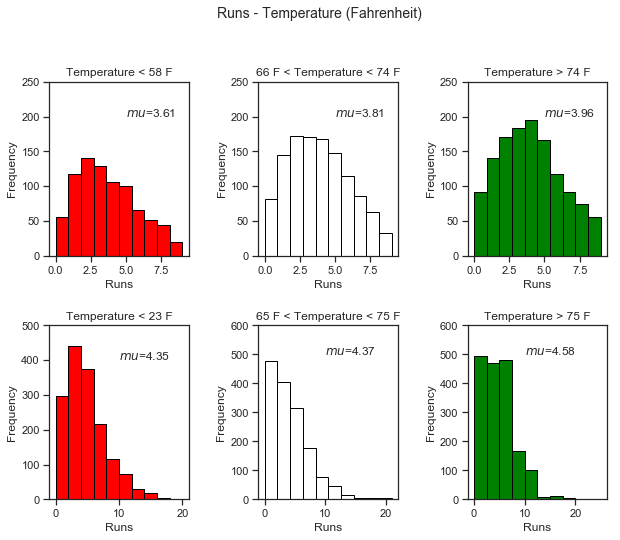

In [16]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Runs - Temperature (Fahrenheit)", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.5, hspace=0.4)

ax1 = fig.add_subplot(2,3, 1)
ax1.set_title("Temperature < {} F".format(min(games1['Temp'][games1['Temp_Level1']==1])))
ax1.set_xlabel("Runs")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 250])
ax1.text(5, 200, r'$mu$='+str(round(games1['Runs'][games1['Temp_Level1']==1].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(games1['Runs'][games1['Temp_Level1']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(2,3, 2)
ax2.set_title("{0} F < Temperature < {1} F".format(min(games1['Temp'][games1['Temp_Level1']==2]), min(games1['Temp'][games1['Temp_Level1']==3])))
ax2.set_xlabel("Runs")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 250])
ax2.text(5, 200, r'$mu$='+str(round(games1['Runs'][games1['Temp_Level1']==2].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(games1['Runs'][games1['Temp_Level1']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax3 = fig.add_subplot(2,3, 3)
ax3.set_title("Temperature > {0} F".format(min(games1['Temp'][games1['Temp_Level1']==3])))
ax3.set_xlabel("Runs")
ax3.set_ylabel("Frequency")
ax3.set_ylim([0, 250])
ax3.text(5, 200, r'$mu$='+str(round(games1['Runs'][games1['Temp_Level1']==3].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax3.hist(games1['Runs'][games1['Temp_Level1']==3], color='green', bins=10,
                                     edgecolor='black', linewidth=1)

ax4 = fig.add_subplot(2,3, 4)
ax4.set_title("Temperature < {} F".format(min(games['Temp'][games['Temp_Level']==1])))
ax4.set_xlabel("Runs")
ax4.set_ylabel("Frequency") 
ax4.set_ylim([0, 500])
ax4.text(10, 400, r'$mu$='+str(round(games['Runs'][games['Temp_Level']==1].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax4.hist(games['Runs'][games['Temp_Level']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax5 = fig.add_subplot(2,3, 5)
ax5.set_title("{0} F < Temperature < {1} F".format(min(games['Temp'][games['Temp_Level']==2]), min(games['Temp'][games['Temp_Level']==3])))
ax5.set_xlabel("Runs")
ax5.set_ylabel("Frequency")
ax5.set_ylim([0, 600])
ax5.text(10, 500, r'$mu$='+str(round(games['Runs'][games['Temp_Level']==2].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax5.hist(games['Runs'][games['Temp_Level']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax6 = fig.add_subplot(2,3, 6)
ax6.set_title("Temperature > {0} F".format(min(games['Temp'][games['Temp_Level']==3])))
ax6.set_xlabel("Runs")
ax6.set_ylabel("Frequency")
ax6.set_ylim([0, 600])
ax6.text(10, 500, r'$mu$='+str(round(games['Runs'][games['Temp_Level']==3].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax6.hist(games['Runs'][games['Temp_Level']==3], color='green', bins=10,
                                     edgecolor='black', linewidth=1)

The histograms above show the Runs vs Temperature for intervals [[58,65], [66,73], [74,82]] (low variability section) and [[23,65], [66,74], [75,107]] (all data).  As expected, mean runs scored increased at each temperature range but the differences were small.  The following section seeks to determine if the changes in the means happened by chance or if they were the result of a real effect.

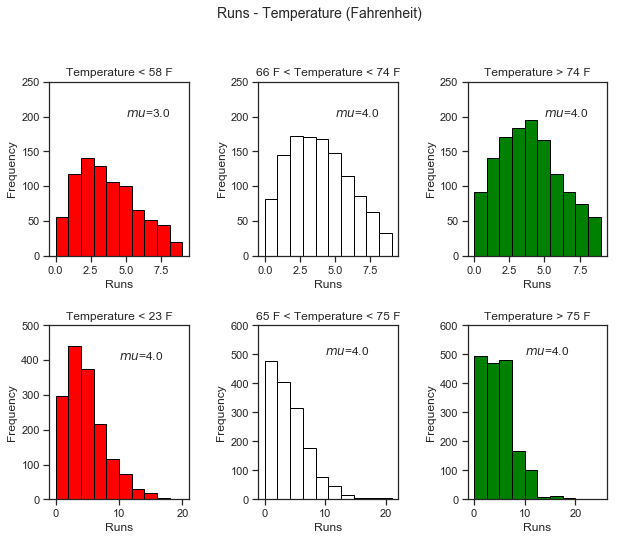

In [17]:
fig = plt.figure(figsize = (10,8))
title = fig.suptitle("Runs - Temperature (Fahrenheit)", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.5, hspace=0.4)

ax1 = fig.add_subplot(2,3, 1)
ax1.set_title("Temperature < {} F".format(min(games1['Temp'][games1['Temp_Level1']==1])))
ax1.set_xlabel("Runs")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 250])
ax1.text(5, 200, r'$mu$='+str(round(games1['Runs'][games1['Temp_Level1']==1].median(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(games1['Runs'][games1['Temp_Level1']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(2,3, 2)
ax2.set_title("{0} F < Temperature < {1} F".format(min(games1['Temp'][games1['Temp_Level1']==2]), min(games1['Temp'][games1['Temp_Level1']==3])))
ax2.set_xlabel("Runs")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 250])
ax2.text(5, 200, r'$mu$='+str(round(games1['Runs'][games1['Temp_Level1']==2].median(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(games1['Runs'][games1['Temp_Level1']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax3 = fig.add_subplot(2,3, 3)
ax3.set_title("Temperature > {0} F".format(min(games1['Temp'][games1['Temp_Level1']==3])))
ax3.set_xlabel("Runs")
ax3.set_ylabel("Frequency")
ax3.set_ylim([0, 250])
ax3.text(5, 200, r'$mu$='+str(round(games1['Runs'][games1['Temp_Level1']==3].median(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax3.hist(games1['Runs'][games1['Temp_Level1']==3], color='green', bins=10,
                                     edgecolor='black', linewidth=1)

ax4 = fig.add_subplot(2,3, 4)
ax4.set_title("Temperature < {} F".format(min(games['Temp'][games['Temp_Level']==1])))
ax4.set_xlabel("Runs")
ax4.set_ylabel("Frequency") 
ax4.set_ylim([0, 500])
ax4.text(10, 400, r'$mu$='+str(round(games['Runs'][games['Temp_Level']==1].median(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax4.hist(games['Runs'][games['Temp_Level']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax5 = fig.add_subplot(2,3, 5)
ax5.set_title("{0} F < Temperature < {1} F".format(min(games['Temp'][games['Temp_Level']==2]), min(games['Temp'][games['Temp_Level']==3])))
ax5.set_xlabel("Runs")
ax5.set_ylabel("Frequency")
ax5.set_ylim([0, 600])
ax5.text(10, 500, r'$mu$='+str(round(games['Runs'][games['Temp_Level']==2].median(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax5.hist(games['Runs'][games['Temp_Level']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax6 = fig.add_subplot(2,3, 6)
ax6.set_title("Temperature > {0} F".format(min(games['Temp'][games['Temp_Level']==3])))
ax6.set_xlabel("Runs")
ax6.set_ylabel("Frequency")
ax6.set_ylim([0, 600])
ax6.text(10, 500, r'$mu$='+str(round(games['Runs'][games['Temp_Level']==3].median(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax6.hist(games['Runs'][games['Temp_Level']==3], color='green', bins=10,
                                     edgecolor='black', linewidth=1)

AttributeError: 'nbinom_gen' object has no attribute 'fit'

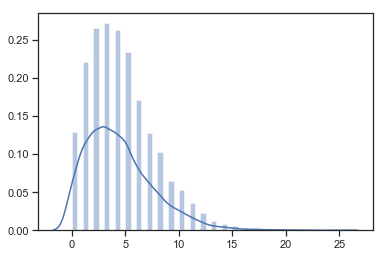

In [22]:
sns.distplot(games['Runs'])
sns.distplot(games1['Runs'])

print("Variance: t1 = {0:5.2f}, t2 = {1:5.2f}, t3 = {2:5.2f}, t_all = {3:5.2f}".format(np.var(t1), np.var(t2), np.var(t3), np.var(t_58_82)))
print("Mean: t1 = {0:4.2f}, t2 = {1:4.2f}, t3 = {2:4.2f}, t_all = {3:4.2f}".format(np.mean(t1), np.mean(t2), np.mean(t3), np.mean(t_58_82)))
print("Median: t1 = {0:4.2f}, t2 = {1:4.2f}, t3 = {2:4.2f}, t_all = {3:4.2f}".format(np.median(t1), np.median(t2), np.median(t3), np.median(t_58_82)))
print("Sample Size: t1 = {0}, t2 = {1}, t3 = {2}, t_all = {3}".format(len(t1), len(t2), len(t3), len(t_58_82)))
print("Proportion: t1 = {0:4.2f}, t2 = {1:4.2f}, t3 = {2:4.2f}\n".format(len(t1)/len(t_58_82), len(t2)/len(t_58_82), len(t3)/len(t_58_82)))
                                                                        
print("Variance: t1A = {0:5.2f}, t2A = {1:5.2f}, t3A = {2:5.2f}, t_all = {3:5.2f}".format(np.var(t1A), np.var(t2A), np.var(t3A), np.var(t_all)))
print("Mean: t1A = {0:4.2f}, t2A = {1:4.2f}, t3A = {2:4.2f}, t_all = {3:4.2f}".format(np.mean(t1A), np.mean(t2A), np.mean(t3A), np.mean(t_all)))
print("Median: t1A = {0:4.2f}, t2A = {1:4.2f}, t3A = {2:4.2f}, t_all = {3:4.2f}".format(np.median(t1A), np.median(t2A), np.median(t3A), np.median(t_all)))
print("Sample Size: t1A = {0}, t2A = {1}, t3A = {2}, t_all = {3}".format(len(t1A), len(t2A), len(t3A), len(t_all)))
print("Proportion: t1A = {0:4.2f}, t2A = {1:4.2f}, t3A = {2:4.2f}\n".format(len(t1A)/len(t_all), len(t2A)/len(t_all), len(t3A)/len(t_all)))

- The distribution skews right and there are small differences in the variances.  
- Count data where the variance is larger than the mean (overdispersed) is often modeled by the Negative Binomial distribution.
    1.  The negative binomial distribution is the probability distribution of the number of successes before the rth failure in a Bernoulli process, with probability p of successes on each trial
    2.  In this case, the successes might be at bats and runs might be failures 
- For large sample sizes, the Central Limit Theorem often enables a distribution to be assumed normal
- Parametric methods often have more power to recognize an existing effect than non-parametric methods
    1.  Normality is necessary for many of these techniques
- Non-parametric methods like bootstrapping are more robust and aren't based on distributional assumptions
    1.  These methods will be used in hypothesis testing to reduce the risk of violating any assumptions

### Linear Regression

In [10]:
X = games1['Temp'] ## X usually means our input variables (or independent variables)
y = games1['Runs'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

C:\Users\mrcrb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Runs   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     13.27
Date:                Mon, 07 Oct 2019   Prob (F-statistic):           0.000274
Time:                        00:00:44   Log-Likelihood:                -7545.1
No. Observations:                3295   AIC:                         1.509e+04
Df Residuals:                    3293   BIC:                         1.511e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1103      0.470      4.485      0.000       1.188       3.033
Temp           0.0243      0.007      3.643      0.000       0.011       0.037
==============================================================================
Omnibus:                      254.355   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.113
Skew:                           0.321   Prob(JB):                     5.58e-29
Kurtosis:                       2.268   Cond. No.                         798.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear regression equation is y = A + Bx.  According to the results:
A = 2.1103
B = 0.0243 (x = Temp)

This indicates there is an increase of 0.0243 runs per degree increase in temperature over the temperature interval (58, 81).  The p-value of 0.000274 is less than the common limit of 0.05 and the hypothesis that there is no relationship between temperature and runs scored can be rejected.  However, even though the difference was found to be significant, only 0.4% (R=0.004) of the variance in runs was found to be the related to temperature changes.

### Sample Confidence Intervals

__Bootstrapping__ is used to estimate the sampling distribution of an estimator by sampling with replacement from the original sample.  Each distribution will be estimated by sampling the original sample 10,000 times.

In [11]:
from sklearn.utils import resample
def bootstrap(sample, resample_size):
    sample_boot = []
    for i in range(resample_size):
        np.random.seed(i)
        sample_boot.append((resample(sample)))
    return sample_boot

t1_bootstrap = bootstrap(t1, 10000)
t1_bootstrap = np.mean(t1_bootstrap, axis=1)
t2_bootstrap = bootstrap(t2, 10000)
t2_bootstrap = np.mean(t2_bootstrap, axis=1)
t3_bootstrap = bootstrap(t3, 10000)
t3_bootstrap = np.mean(t3_bootstrap, axis=1)
t_all_bootstrap = bootstrap(t_all, 10000)
t_all_bootstrap = np.mean(t_all_bootstrap, axis=1)

differences1 = (t3_bootstrap - t1_bootstrap)
differences2 = (t3_bootstrap - t2_bootstrap)
differences3 = (t2_bootstrap - t1_bootstrap)

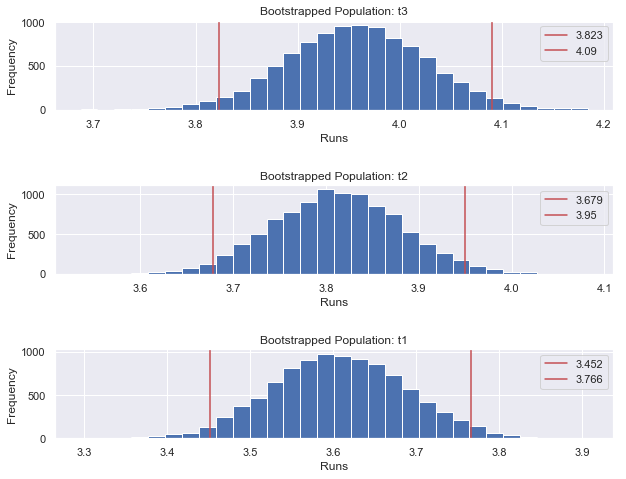

95% Confidence Intervals for Temperature Categories
t3:     Lower bound: 3.823     Upper bound: 4.090
t2:     Lower bound: 3.679     Upper bound: 3.950
t1:     Lower bound: 3.452     Upper bound: 3.766


In [12]:
lower_bound_t3 = np.percentile(t3_bootstrap, 2.5)
upper_bound_t3 = np.percentile(t3_bootstrap, 97.5)

fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.85, wspace=0.3)

ax1 = fig.add_subplot(3,1, 1)
ax1.set_xlabel('Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound_t3, color='r', label=round(lower_bound_t3,3))
ax1.axvline(upper_bound_t3, color='r', label=round(upper_bound_t3,3))
ax1.set_title('Bootstrapped Population: t3')
ax1_hist = ax1.hist(t3_bootstrap, bins=30)
ax1.legend()

lower_bound_t2 = np.percentile(t2_bootstrap, 2.5)
upper_bound_t2 = np.percentile(t2_bootstrap, 97.5)

ax2 = fig.add_subplot(3,1, 2)
ax2.set_xlabel('Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound_t2, color='r', label=round(lower_bound_t2,3))
ax2.axvline(upper_bound_t2, color='r', label=round(upper_bound_t2,3))
ax2.set_title('Bootstrapped Population: t2')
ax2_hist = ax2.hist(t2_bootstrap, bins=30)
ax2.legend()

lower_bound_t1 = np.percentile(t1_bootstrap, 2.5)
upper_bound_t1 = np.percentile(t1_bootstrap, 97.5)

ax3 = fig.add_subplot(3,1, 3)
ax3.set_xlabel('Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound_t1, color='r', label=round(lower_bound_t1,3))
ax3.axvline(upper_bound_t1, color='r', label=round(upper_bound_t1,3))
ax3.set_title('Bootstrapped Population: t1')
ax3_hist = ax3.hist(t1_bootstrap, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Temperature Categories')
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("t3", lower_bound_t3, upper_bound_t3))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("t2", lower_bound_t2, upper_bound_t2))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("t1", lower_bound_t1, upper_bound_t1))

#### All three distributions on one chart

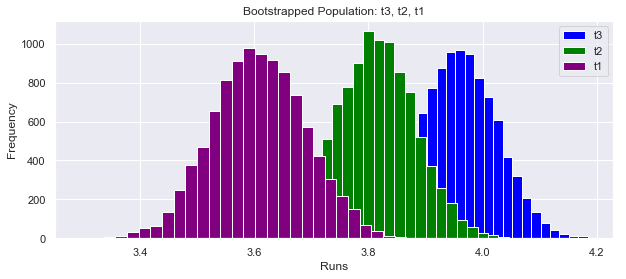

In [13]:
fig = plt.figure(figsize=(10,4))

plt.xlabel('Runs')
plt.ylabel('Frequency')
plt.title('Bootstrapped Population: t3, t2, t1')
ax1 = plt.hist(t3_bootstrap, bins=30, color='blue', label='t3')
ax2 = plt.hist(t2_bootstrap, bins=30, color='green', label='t2')
ax3 = plt.hist(t1_bootstrap, bins=30, color='purple', label='t1')
plt.legend()
plt.show()

The confidence intervals obtained from bootstrapping have a range of about 0.3 runs.  The overlap of the distributions indicates it's possible there is no actual difference in the means.  This information is much more useful if a level of confidence in the existence of the effect can be established.  The confidence level of the mean differences is calculated below.

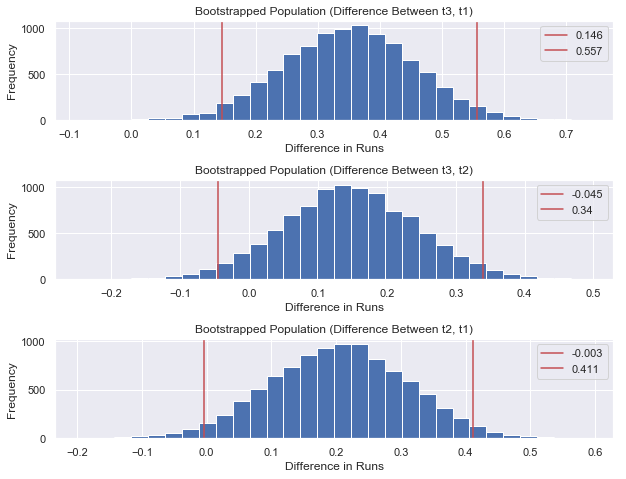

95% Confidence Intervals for Mean Differce between t3 & t1:
Lower bound: 0.146
Upper bound: 0.557
Number of samples where (mean) t1 > t3: 5

95% Confidence Intervals for Mean Differce between t3 & t2:
Lower bound: -0.045
Upper bound: 0.340
Number of samples where (mean) t2 > t3: 688

95% Confidence Intervals for Mean Differce between t2 & t1:
Lower bound: -0.003
Upper bound: 0.411
Number of samples where (mean) t2 > t1: 271


In [14]:
lower_bound1 = np.percentile(differences1, 2.5)
upper_bound1 = np.percentile(differences1, 97.5)
lower_bound2 = np.percentile(differences2, 2.5)
upper_bound2 = np.percentile(differences2, 97.5)
lower_bound3 = np.percentile(differences3, 2.5)
upper_bound3 = np.percentile(differences3, 97.5)

fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.6)

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('Difference in Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound1, color='r', label=round(lower_bound1,3))
ax1.axvline(upper_bound1, color='r', label=round(upper_bound1,3))
ax1.set_title('Bootstrapped Population (Difference Between t3, t1)')
ax1_hist = ax1.hist(differences1, bins=30)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('Difference in Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound2, color='r', label=round(lower_bound2,3))
ax2.axvline(upper_bound2, color='r', label=round(upper_bound2,3))
ax2.set_title('Bootstrapped Population (Difference Between t3, t2)')
ax2_hist = ax2.hist(differences2, bins=30)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('Difference in Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound3, color='r', label=round(lower_bound3,3))
ax3.axvline(upper_bound3, color='r', label=round(upper_bound3,3))
ax3.set_title('Bootstrapped Population (Difference Between t2, t1)')
ax3_hist = ax3.hist(differences3, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('t3', 't1'))
print('Lower bound: {0:5.3f}'.format(lower_bound1))
print('Upper bound: {0:5.3f}'.format(upper_bound1))

p1 = differences1[differences1 <= 0].shape[0]
print("Number of samples where (mean) t1 > t3: {}\n".format(p1))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('t3', 't2'))
print('Lower bound: {0:5.3f}'.format(lower_bound2))
print('Upper bound: {0:5.3f}'.format(upper_bound2))

p2 = differences2[differences2 <= 0].shape[0]
print("Number of samples where (mean) t2 > t3: {}\n".format(p2))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('t2', 't1'))
print('Lower bound: {0:5.3f}'.format(lower_bound3))
print('Upper bound: {0:5.3f}'.format(upper_bound3))

p3 = differences3[differences3 <= 0].shape[0]
print("Number of samples where (mean) t2 > t1: {}".format(p3))

### Mean difference between t3 and t1
- Only 5 out of 10,000 had a mean difference larger than zero
- It can be said with 95% certainty that the mean difference between groups falls between 0.146 and 0.557

### Mean difference between t3 and t2
- Only 688 out of 10,000 had a mean difference larger than zero.  
- There is 95% certainty that the mean difference between groups falls between -0.045 and 0.340

### Mean difference between t2 and t1
- Only 271 out of 10,000 had a mean difference larger than zero.  
- There is 95% certainty that the mean difference between groups falls between -0.0003 and 0.411

### Comparing results to more traditional methods
The intervals attained from bootstrapping can be compared to values calculated by the StatsModels module.

In [15]:
import numpy as np, statsmodels.stats.api as sms

cm = sms.CompareMeans(sms.DescrStatsW(t3), sms.DescrStatsW(t2))
print("--------------------------------------------------------------")
print("Confidence Intervals: Mean Difference Between {} & {}".format('t3', 't2'))
print("--------------------------------------------------------------")
print("Stats: {0:5.3f}, {1:5.3f}".format(cm.tconfint_diff(usevar='unequal')[0], cm.tconfint_diff(usevar='unequal')[1]))
print("Bootstrap: {0:5.3f}, {1:5.3f}\n".format(lower_bound2, upper_bound2))

cm = sms.CompareMeans(sms.DescrStatsW(t3), sms.DescrStatsW(t1))
print("--------------------------------------------------------------")
print("Confidence Intervals: Mean Difference Between {} & {}".format('t3', 't1'))
print("--------------------------------------------------------------")
print("Stats: {0:5.3f}, {1:5.3f}".format(cm.tconfint_diff(usevar='unequal')[0], cm.tconfint_diff(usevar='unequal')[1]))
print("Bootstrap: {0:5.3f}, {1:5.3f}\n".format(lower_bound1, upper_bound1))

cm = sms.CompareMeans(sms.DescrStatsW(t2), sms.DescrStatsW(t1))
print("--------------------------------------------------------------")
print("Confidence Intervals: Mean Difference Between {} & {}".format('t2', 't1'))
print("--------------------------------------------------------------")
print("Stats: {0:5.3f}, {1:5.3f}".format(cm.tconfint_diff(usevar='unequal')[0], cm.tconfint_diff(usevar='unequal')[1]))
print("Bootstrap: {0:5.3f}, {1:5.3f}".format(lower_bound3, upper_bound3))

--------------------------------------------------------------
Confidence Intervals: Mean Difference Between t3 & t2
--------------------------------------------------------------
Stats: -0.044, 0.336
Bootstrap: -0.045, 0.340

--------------------------------------------------------------
Confidence Intervals: Mean Difference Between t3 & t1
--------------------------------------------------------------
Stats: 0.143, 0.559
Bootstrap: 0.146, 0.557

--------------------------------------------------------------
Confidence Intervals: Mean Difference Between t2 & t1
--------------------------------------------------------------
Stats: -0.005, 0.414
Bootstrap: -0.003, 0.411


The lower and upper bounds from the statsmodels program are nearly identical to those found using bootstrapping.

In [16]:
combined = np.concatenate((t3, t2, t1), axis=0)

perms_t1 = []
perms_t2 = []
perms_t3 = []

for i in range(10000):
    np.random.seed(i)
    perms_t1.append(resample(combined, n_samples = len(t1)))
    perms_t2.append(resample(combined, n_samples = len(t2)))
    perms_t3.append(resample(combined, n_samples = len(t3)))
    
dif_bootstrap_means1 = (np.mean(perms_t3, axis=1)-np.mean(perms_t1, axis=1))
dif_bootstrap_means2 = (np.mean(perms_t3, axis=1)-np.mean(perms_t2, axis=1))
dif_bootstrap_means3 = (np.mean(perms_t2, axis=1)-np.mean(perms_t1, axis=1))

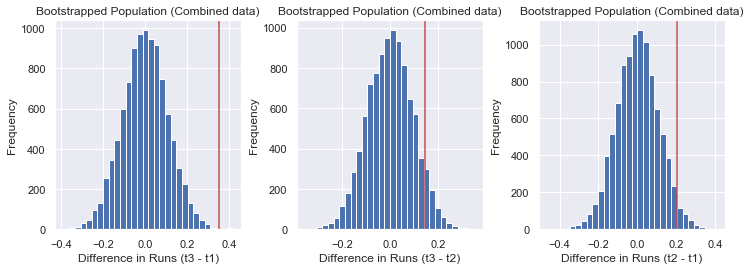

observed difference in means: 0.3505 [t3,t1]
observed difference in means: 0.1460 [t3,t2]
observed difference in means: 0.2045 [t2,t1]
p-value: 0.0007 [t3,t1]
p-value: 0.0655 [t3,t2]
p-value: 0.0283 [t2,t1]


In [17]:
obs_difs1 = np.mean(t3) - np.mean(t1)
obs_difs2 = np.mean(t3) - np.mean(t2)
obs_difs3 = np.mean(t2) - np.mean(t1)

p_value1 = dif_bootstrap_means1[dif_bootstrap_means1 >= obs_difs1].shape[0]/10000
p_value2 = dif_bootstrap_means2[dif_bootstrap_means2 >= obs_difs2].shape[0]/10000
p_value3 = dif_bootstrap_means3[dif_bootstrap_means3 >= obs_difs3].shape[0]/10000

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_xlabel('Difference in Runs (t3 - t1)')
ax1.set_ylabel('Frequency')
ax1.set_title('Bootstrapped Population (Combined data)')
ax1.axvline(obs_difs1, color='r')
d1 = ax1.hist(dif_bootstrap_means1, bins=30)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_xlabel('Difference in Runs (t3 - t2)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrapped Population (Combined data)')
ax2.axvline(obs_difs2, color='r')
d2 = ax2.hist(dif_bootstrap_means2, bins=30)

ax3 = fig.add_subplot(1,3, 3)
ax3.set_xlabel('Difference in Runs (t2 - t1)')
ax3.set_ylabel('Frequency')
ax3.set_title('Bootstrapped Population (Combined data)')
ax3.axvline(obs_difs3, color='r')
d3 = ax3.hist(dif_bootstrap_means3, bins=30)
plt.show()

print('observed difference in means: {0:5.4f} [t3,t1]'.format(obs_difs1))
print('observed difference in means: {0:5.4f} [t3,t2]'.format(obs_difs2))
print('observed difference in means: {0:5.4f} [t2,t1]'.format(obs_difs3))

print('p-value: {} [t3,t1]'.format(p_value1))
print('p-value: {} [t3,t2]'.format(p_value2))
print('p-value: {} [t2,t1]'.format(p_value3))

__t3 - t1__  
Only 7 (p-value = 0.0007) of the samples had a mean larger than 0.35 runs. <br>
H0: t3 & t1 have identical expected means.  <font color=red>[Rejected]</font>  

__t3 - t2__  
Only 655 (p-value = 0.0655) out of 10,000 had a mean larger than the observed mean difference of 0.15 runs. <br>
H0: t3 & t2 have identical expected means.  <font color=red>[Not Rejected]</font>

__t2 - t1__  
Only 283 (p-value = 0.0283) out of 10,000 had a mean larger than the observed mean difference of 0.20 runs. <br>
H0: t2 & t1 have identical expected means.  <font color=red>[Not Rejected]</font>

The __observed difference in means__ is the difference between the observed mean and the expected mean of a sample of equal size taken from the total population. 

The run difference of 0.35 between (t3, t1) is significant as it is unlikely this result would be obtained if an equal size sample was randomly selected from the population.  The mean difference between (t3, t2) cannot be considered significant as it would be likely to occur by chance approximately 1 in 15 times.  The null hypothesis is rejected for (t2, t1).
    
The smaller p-values between the adjacent variables (smallest temp diff) might be the result of a small effect size, small sample size or a combination of the two.  This may have prevented an effect from being found when it exists, which means the null is retained when it should have been rejected (Type 2 Error).  It is also possible there is no actual difference between (t3, t1) an the null was rejected when it was correct (Type 1 Error).

### Results compared to methods in the scipy stats library

The __One-Way ANOVA__ method is a parametric test that checks if the means of the measurement variable are different for different groups.  It doesn't indicate which or how many of the samples exhibit stochastic dominance, so further analysis is required to compare groups on a 1 to 1 basis.

The ANOVA test assumes:
1. Samples are normal
2. Samples have equal standard deviations

Sample sizes larger than 30 can usually be considered normal and the difference in the variances is not aggregious, so any individual impact on the results is likely minimal.  However, differences in the sample sizes can exaserbate the effect of heteroscedasticity on the results.

The removal of outliers and limiting the data to a temperature range with larger sample sizes should limit the effects of the unequal sample sizes and small variations in standard deviation.  One-way ANOVA is used but it would have been reasonable to sacrifice some power and use the Welch's ANOVA.

H0: The means of t1, t2, t3 are the same

In [18]:
anova = stats.f_oneway(t3, t2, t1)
print("anova p-value: {0:5.4f}".format(anova[1]))
print("anova z-value: {0:5.2f}".format(anova[0]))

anova p-value: 0.0045
anova z-value:  5.42


The __ANOVA__ p-value (0.0045) suggests that there is a significant difference in the mean of at least one group.  Post-hoc tests are needed to determine which group or groups.

H0: The means of t1, t2, t3 are the same <font color=red>[Rejected]</font>

In [19]:
rho, pval = stats.spearmanr(games1['Temp_Level1'], games1['Runs'])
print("spearman p-value: {0:4.3f}".format(pval))
print("spearman rho-value: {0:4.3f}".format(rho))

spearman p-value: 0.001
spearman rho-value: 0.056


The __Spearman Rank Correlation__ measures the association between variables.  It is generally used on 2 ranked variables or a ranked and a measured variable.  The spearman rho value ranges between -1 and 1, where 1 and -1 indicate a perfect correlation, 0 indicates no correlation, and the sign indicates if the relationship is positive (+rho) or negative (-rho).  The p-value (0.001) indicates the relationship between temperature and runs is a significant.  However, a rho variable of (0.056) indicates that the relationship is very weak, which means increases in temperature correspond with very small increses in runs.

H0: Runs scored don't increase as temperature rank increases. (RHO equals zero) <font color=red>[Rejected]</font>

In [20]:
pt = pg.pairwise_tukey(dv='Runs', between='Temp_Level1', data=games1, tail='one-sided')
print(pt)

   A  B   mean(A)   mean(B)      diff     SE       tail      T   p-tukey  \
0  1  2  3.607488  3.812024 -0.204536  0.108  one-sided -1.887  0.071211   
1  1  3  3.607488  3.958009 -0.350521  0.107  one-sided -3.290  0.001442   
2  2  3  3.812024  3.958009 -0.145986  0.096  one-sided -1.515  0.142175   

   efsize  eftype  
0  -0.086  hedges  
1  -0.147  hedges  
2  -0.061  hedges  


The __Tukey-Kramer Post-Hoc__ test compares groups and or combinations of groups.  It establishes a minimum significant difference for each pair of means based on group size, variance and number of groups, and then compares it to the observed difference in means between the groups.  
The test results slightly differ from the results of the bootstrap method.  The null for (t3,t2) and (t2,t1) is retained and the null for (t3,t1) is rejected.  The Hedges (adjusted Cohen) effect size of 0.147 is small and seems to backup the results of the Spearman Rho.  The confidence intervals of the mean differences (diff - SE x t, diff + SE x t) are slightly smaller but very similiar to the ones achieved during bootstrapping.

For t1, t3:
Turkey-Kramer: (-0.0015 < CI < 0.7)
Bootstrap: (0.146 < CI < 0.557)

The following section repeats the above tests with __outliers__.  

In [21]:
# Create data frame for games with temps between 58 and 81
games2 = games[(games['Temp'] >= 58) & (games['Temp'] < 82)].copy()

games2['Temp_Level1'] = 0
games2.loc[games2.Temp < 66, 'Temp_Level1'] = 1
games2.loc[(games2.Temp >= 66) & (games2.Temp < 74), 'Temp_Level1'] = 2
games2.loc[games2.Temp >= 74, 'Temp_Level1'] = 3

t1A = games2['Runs'][(games2['Temp_Level1']==1)]
t2A = games2['Runs'][(games2['Temp_Level1']==2)]
t3A = games2['Runs'][(games2['Temp_Level1']==3)]

anova = stats.f_oneway(t1A, t2A, t3A)
print("anova p-value: {0:5.4f}".format(anova[1]))
print("anova z-value: {0:5.2f}\n".format(anova[0]))

kruskal = stats.kruskal(t1A, t2A, t3A, equal_var = False)
print("Kruskal p-value: {0:6.4f}".format(kruskal[1]))
print("Kruskal z-value: {0:4.2f}\n".format(kruskal[0]))

rho, pval = stats.spearmanr(games2['Temp_Level1'], games2['Runs'])
print("spearman p-value: {0:4.3f}".format(pval))
print("spearman rho-value: {0:4.3f}\n".format(rho))

pt1 = pg.pairwise_tukey(dv='Runs', between='Temp_Level1', data=games2, tail='one-sided')
print(pt1)

anova p-value: 0.0902
anova z-value:  2.41

Kruskal p-value: 0.0215
Kruskal z-value: 7.68

spearman p-value: 0.007
spearman rho-value: 0.045

   A  B   mean(A)   mean(B)      diff     SE       tail      T   p-tukey  \
0  1  2  4.171910  4.361987 -0.190077  0.136  one-sided -1.398  0.171456   
1  1  3  4.171910  4.465116 -0.293206  0.134  one-sided -2.192  0.036343   
2  2  3  4.361987  4.465116 -0.103129  0.121  one-sided -0.852  0.378048   

   efsize  eftype  
0  -0.061  hedges  
1  -0.094  hedges  
2  -0.033  hedges  


The ANOVA of the sample with outliers has a p-value of 0.09, which is larger than the accepted threshold.  However, the Tukey-Kramer still shows a significant difference between T1 and T3.  The significance level and effect size is reduced.  The outliers in conjunction with imbalanced data likely prevented the test from seeing an effect.  THe Kruskal-Wallis test is less effected by outliers because it compares the mean ranks, which are the medians if the sample distributions are the same.  As expected, the Kruskal-Wallis test was more resilient to outliers and  returned a p-value of 0.0215.

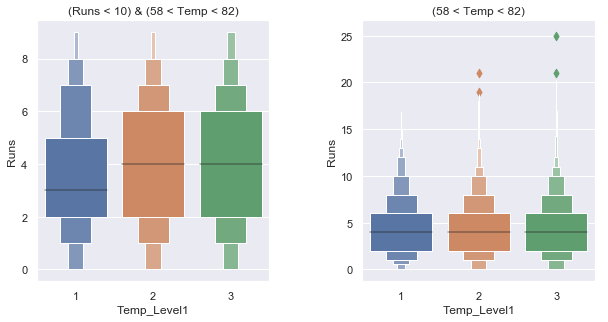

In [22]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(top=0.85, hspace=0.6, wspace = 0.4)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("(Runs < 10) & (58 < Temp < 82)")
g1 = sns.boxenplot('Temp_Level1', 'Runs', data=games1)
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("(58 < Temp < 82)")
g2 = sns.boxenplot('Temp_Level1', 'Runs', data=games2)
plt.show()

### __Humidity__

In [23]:
h33 = 62 # np.percentile(games['Humidity'], 33, axis=0)
h66 = 76 # np.percentile(games['Humidity'], 66, axis=0)

In [24]:
# Create data frame for games with temps between 58 and 81
games2 = games[(games['Humidity'] >= 47) & (games['Humidity'] < 91) & (games['Runs'] < 10)].copy()

h1 = games2['Runs'][(games2['Humidity'] >= 47) & (games2['Humidity'] < 62)]
h2 = games2['Runs'][(games2['Humidity'] >= 62) & (games2['Humidity'] < 76)]
h3 = games2['Runs'][(games2['Humidity'] >= 76) & (games2['Humidity'] < 91)]

games2['Humidity_Level1'] = 0
games2.loc[games2.Humidity < 66, 'Humidity_Level1'] = 1
games2.loc[(games2.Humidity >= 66) & (games2.Temp < 74), 'Humidity_Level1'] = 2
games2.loc[games2.Humidity >= 74, 'Humidity_Level1'] = 3

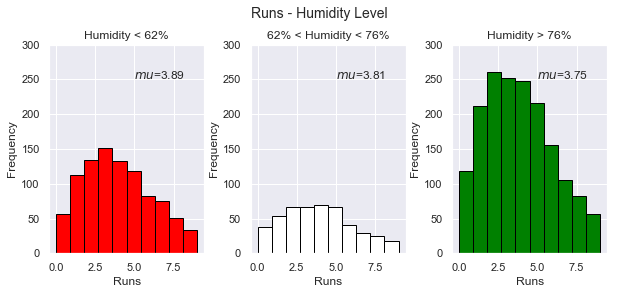

In [25]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Runs - Humidity Level", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_title("Humidity < {}%".format(h33))
ax1.set_xlabel("Runs")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 300])
ax1.text(5, 250, r'$mu$='+str(round(games2['Runs'][games2['Humidity_Level1']==1].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(games2['Runs'][games2['Humidity_Level1']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_title("{0}% < Humidity < {1}%".format(h33, h66))
ax2.set_xlabel("Runs")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 300])
ax2.text(5, 250, r'$mu$='+str(round(games2['Runs'][games2['Humidity_Level1']==2].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(games2['Runs'][games2['Humidity_Level1']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax3 = fig.add_subplot(1,3, 3)
ax3.set_title("Humidity > {}%".format(h66))
ax3.set_xlabel("Runs")
ax3.set_ylabel("Frequency")
ax3.set_ylim([0, 300])
ax3.text(5, 250, r'$mu$='+str(round(games2['Runs'][games2['Humidity_Level1']==3].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax3.hist(games2['Runs'][games2['Humidity_Level1']==3], color='green', bins=10,
                                      edgecolor='black', linewidth=1)

There is less between-group difference than with the temperature groups.  A quick exploration is likely all that is warranted.

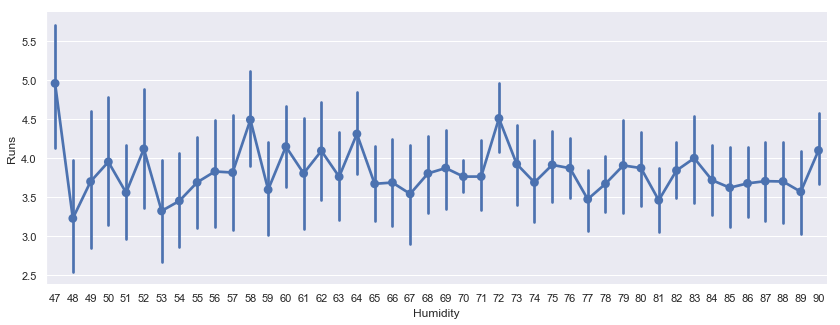

In [26]:
sns.set()
f, ax = plt.subplots(figsize=(14, 5))
sns.pointplot('Humidity', 'Runs', data=games2)
sns.despine(bottom=True)
plt.show()

In [27]:
X = games2['Humidity'] ## X usually means our input variables (or independent variables)
y = games2['Runs'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

C:\Users\mrcrb\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Runs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9227
Date:                Mon, 07 Oct 2019   Prob (F-statistic):              0.337
Time:                        00:01:36   Log-Likelihood:                -8547.8
No. Observations:                3738   AIC:                         1.710e+04
Df Residuals:                    3736   BIC:                         1.711e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0664      0.266     15.298      0.000       3.545       4.588
Humidity      -0.0035      0.004     -0.961      0.337      -0.011       0.004
==============================================================================
Omnibus:                      262.077   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              145.580
Skew:                           0.333   Prob(JB):                     2.44e-32
Kurtosis:                       2.299   Cond. No.                         497.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
h1_bootstrap = bootstrap(h1, 10000)
h1_bootstrap = np.mean(h1_bootstrap, axis=1)
h2_bootstrap = bootstrap(h2, 10000)
h2_bootstrap = np.mean(h2_bootstrap, axis=1)
h3_bootstrap = bootstrap(h3, 10000)
h3_bootstrap = np.mean(h3_bootstrap, axis=1)
#h_all_bootstrap = bootstrap(h_all, 10000)
#h_all_bootstrap = np.mean(h_all_bootstrap, axis=1)

differences1 = (h1_bootstrap - h3_bootstrap)
differences2 = (h2_bootstrap - h3_bootstrap)
differences3 = (h1_bootstrap - h2_bootstrap)

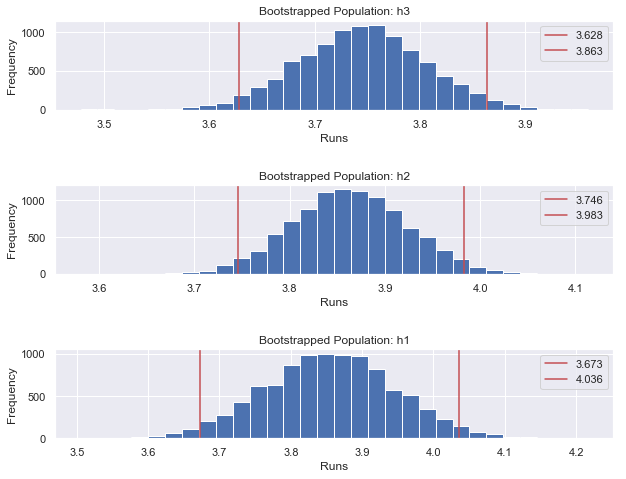

95% Confidence Intervals for Temperature Categories
h3:     Lower bound: 3.628     Upper bound: 3.863
h2:     Lower bound: 3.746     Upper bound: 3.983
h1:     Lower bound: 3.673     Upper bound: 4.036


In [29]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.85, wspace=0.3)

lower_bound_h3 = np.percentile(h3_bootstrap, 2.5)
upper_bound_h3 = np.percentile(h3_bootstrap, 97.5)

ax1 = fig.add_subplot(3,1, 1)
ax1.set_xlabel('Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound_h3, color='r', label=round(lower_bound_h3,3))
ax1.axvline(upper_bound_h3, color='r', label=round(upper_bound_h3,3))
ax1.set_title('Bootstrapped Population: h3')
ax1_hist = ax1.hist(h3_bootstrap, bins=30)
ax1.legend()

lower_bound_h2 = np.percentile(h2_bootstrap, 2.5)
upper_bound_h2 = np.percentile(h2_bootstrap, 97.5)

ax2 = fig.add_subplot(3,1, 2)
ax2.set_xlabel('Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound_h2, color='r', label=round(lower_bound_h2,3))
ax2.axvline(upper_bound_h2, color='r', label=round(upper_bound_h2,3))
ax2.set_title('Bootstrapped Population: h2')
ax2_hist = ax2.hist(h2_bootstrap, bins=30)
ax2.legend()

lower_bound_h1 = np.percentile(h1_bootstrap, 2.5)
upper_bound_h1 = np.percentile(h1_bootstrap, 97.5)

ax3 = fig.add_subplot(3,1, 3)
ax3.set_xlabel('Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound_h1, color='r', label=round(lower_bound_h1,3))
ax3.axvline(upper_bound_h1, color='r', label=round(upper_bound_h1,3))
ax3.set_title('Bootstrapped Population: h1')
ax3_hist = ax3.hist(h1_bootstrap, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Temperature Categories')
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("h3", lower_bound_h3, upper_bound_h3))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("h2", lower_bound_h2, upper_bound_h2))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("h1", lower_bound_h1, upper_bound_h1))

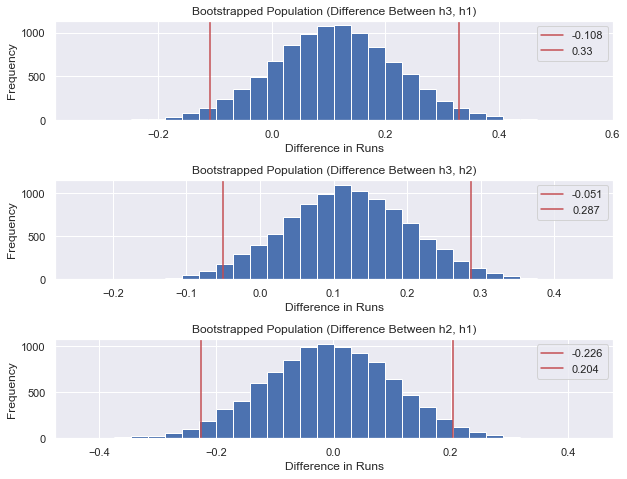

95% Confidence Intervals for Mean Differce between h1 & h3:
Lower bound: -0.108
Upper bound: 0.330
Number of samples where (mean) h3 > h1: 1592

95% Confidence Intervals for Mean Differce between h2 & h3:
Lower bound: -0.051
Upper bound: 0.287
Number of samples where (mean) h3 > h2: 875

95% Confidence Intervals for Mean Differce between h1 & h2:
Lower bound: -0.226
Upper bound: 0.204
Number of samples where (mean) h2 > h1: 5277


In [30]:
lower_bound1 = np.percentile(differences1, 2.5)
upper_bound1 = np.percentile(differences1, 97.5)
lower_bound2 = np.percentile(differences2, 2.5)
upper_bound2 = np.percentile(differences2, 97.5)
lower_bound3 = np.percentile(differences3, 2.5)
upper_bound3 = np.percentile(differences3, 97.5)

fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.6)

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('Difference in Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound1, color='r', label=round(lower_bound1,3))
ax1.axvline(upper_bound1, color='r', label=round(upper_bound1,3))
ax1.set_title('Bootstrapped Population (Difference Between h3, h1)')
ax1_hist = ax1.hist(differences1, bins=30)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('Difference in Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound2, color='r', label=round(lower_bound2,3))
ax2.axvline(upper_bound2, color='r', label=round(upper_bound2,3))
ax2.set_title('Bootstrapped Population (Difference Between h3, h2)')
ax2_hist = ax2.hist(differences2, bins=30)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('Difference in Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound3, color='r', label=round(lower_bound3,3))
ax3.axvline(upper_bound3, color='r', label=round(upper_bound3,3))
ax3.set_title('Bootstrapped Population (Difference Between h2, h1)')
ax3_hist = ax3.hist(differences3, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('h1', 'h3'))
print('Lower bound: {0:5.3f}'.format(lower_bound1))
print('Upper bound: {0:5.3f}'.format(upper_bound1))

p1 = differences1[differences1 <= 0].shape[0]
print("Number of samples where (mean) h3 > h1: {}\n".format(p1))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('h2', 'h3'))
print('Lower bound: {0:5.3f}'.format(lower_bound2))
print('Upper bound: {0:5.3f}'.format(upper_bound2))

p2 = differences2[differences2 <= 0].shape[0]
print("Number of samples where (mean) h3 > h2: {}\n".format(p2))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('h1', 'h2'))
print('Lower bound: {0:5.3f}'.format(lower_bound3))
print('Upper bound: {0:5.3f}'.format(upper_bound3))

p3 = differences3[differences3 <= 0].shape[0]
print("Number of samples where (mean) h2 > h1: {}".format(p3))

In [31]:
combined = np.concatenate((h3, h2, h1), axis=0)

perms_h1 = []
perms_h2 = []
perms_h3 = []

for i in range(10000):
    np.random.seed(i)
    perms_h1.append(resample(combined, n_samples = len(h1)))
    perms_h2.append(resample(combined, n_samples = len(h2)))
    perms_h3.append(resample(combined, n_samples = len(h3)))
    
dif_bootstrap_means1 = (np.mean(perms_h1, axis=1)-np.mean(perms_h3, axis=1))
dif_bootstrap_means2 = (np.mean(perms_h2, axis=1)-np.mean(perms_h3, axis=1))
dif_bootstrap_means3 = (np.mean(perms_h1, axis=1)-np.mean(perms_h2, axis=1))

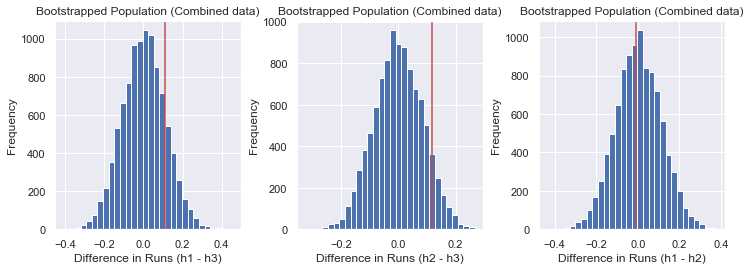

observed difference in means: 0.1100 [h1,h3]
observed difference in means: 0.1191 [h2,h3]
observed difference in means: -0.0091 [h1,h2]
p-value: 0.1601 [h3,h1]
p-value: 0.08 [h3,h2]
p-value: 0.5375 [h2,h1]


In [32]:
obs_difs1 = np.mean(h1) - np.mean(h3)
obs_difs2 = np.mean(h2) - np.mean(h3)
obs_difs3 = np.mean(h1) - np.mean(h2)

p_value1 = dif_bootstrap_means1[dif_bootstrap_means1 >= obs_difs1].shape[0]/10000
p_value2 = dif_bootstrap_means2[dif_bootstrap_means2 >= obs_difs2].shape[0]/10000
p_value3 = dif_bootstrap_means3[dif_bootstrap_means3 >= obs_difs3].shape[0]/10000

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_xlabel('Difference in Runs (h1 - h3)')
ax1.set_ylabel('Frequency')
ax1.set_title('Bootstrapped Population (Combined data)')
ax1.axvline(obs_difs1, color='r')
d1 = ax1.hist(dif_bootstrap_means1, bins=30)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_xlabel('Difference in Runs (h2 - h3)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrapped Population (Combined data)')
ax2.axvline(obs_difs2, color='r')
d2 = ax2.hist(dif_bootstrap_means2, bins=30)

ax3 = fig.add_subplot(1,3, 3)
ax3.set_xlabel('Difference in Runs (h1 - h2)')
ax3.set_ylabel('Frequency')
ax3.set_title('Bootstrapped Population (Combined data)')
ax3.axvline(obs_difs3, color='r')
d3 = ax3.hist(dif_bootstrap_means3, bins=30)
plt.show()

print('observed difference in means: {0:5.4f} [h1,h3]'.format(obs_difs1))
print('observed difference in means: {0:5.4f} [h2,h3]'.format(obs_difs2))
print('observed difference in means: {0:5.4f} [h1,h2]'.format(obs_difs3))

print('p-value: {} [h3,h1]'.format(p_value1))
print('p-value: {} [h3,h2]'.format(p_value2))
print('p-value: {} [h2,h1]'.format(p_value3))

In [33]:
anova = stats.f_oneway(h1, h2, h3)
print("anova p-value: {0:5.4f}".format(anova[1]))
print("anova z-value: {0:5.2f}\n".format(anova[0]))

anova p-value: 0.3397
anova z-value:  1.08



A p-value of 0.34 is much larger than the standard 0.05 commonly used as a threshold.  The null hypothesis is accepted.

### __Wind__

In [34]:
# Create data frame for games3 with temps between -10 and 10
games3 = games[(games['Wind'] >= -10) & (games['Wind'] < 10) & (games['Runs'] < 10)].copy()

w1 = games3['Runs'][(games3['Wind'] >= -10) & (games3['Wind'] < -3)]
w2 = games3['Runs'][(games3['Wind'] >= -3) & (games3['Wind'] < 3)]
w3 = games3['Runs'][(games3['Wind'] >= 3) & (games3['Wind'] < 10)]

games3['Wind_Level1'] = 0
games3.loc[games3.Wind < -3, 'Wind_Level1'] = 1
games3.loc[(games3.Wind >= -3) & (games3.Wind < 3), 'Wind_Level1'] = 2
games3.loc[games3.Wind >= 3, 'Wind_Level1'] = 3

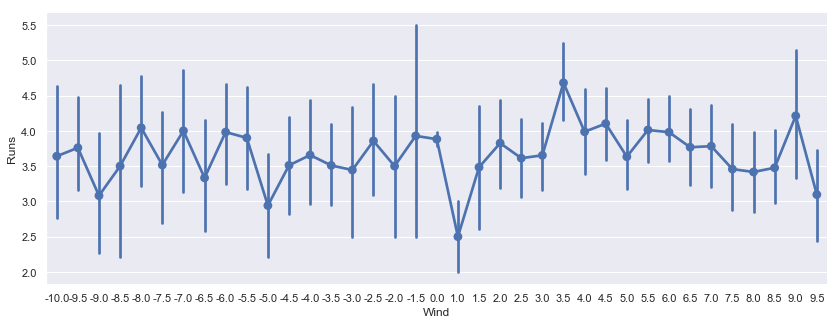

In [35]:
sns.set()
f, ax = plt.subplots(figsize=(14, 5))
sns.pointplot('Wind', 'Runs', data=games3)
sns.despine(bottom=True)
plt.show()

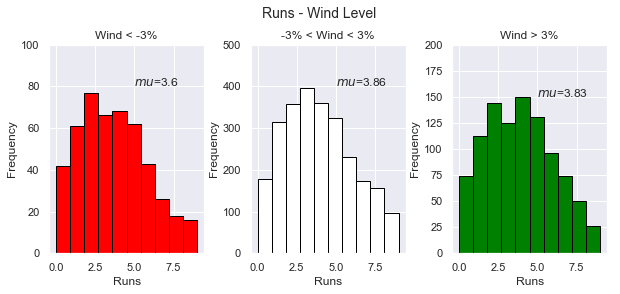

In [36]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Runs - Wind Level", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_title("Wind < {}%".format(-3))
ax1.set_xlabel("Runs")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 100])
ax1.text(5, 80, r'$mu$='+str(round(games3['Runs'][games3['Wind_Level1']==1].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(games3['Runs'][games3['Wind_Level1']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_title("{0}% < Wind < {1}%".format(-3, 3))
ax2.set_xlabel("Runs")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 500])
ax2.text(5, 400, r'$mu$='+str(round(games3['Runs'][games3['Wind_Level1']==2].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(games3['Runs'][games3['Wind_Level1']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax3 = fig.add_subplot(1,3, 3)
ax3.set_title("Wind > {}%".format(3))
ax3.set_xlabel("Runs")
ax3.set_ylabel("Frequency")
ax3.set_ylim([0, 200])
ax3.text(5, 150, r'$mu$='+str(round(games3['Runs'][games3['Wind_Level1']==3].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax3.hist(games3['Runs'][games3['Wind_Level1']==3], color='green', bins=10,
                                      edgecolor='black', linewidth=1)

In [37]:
X = games3['Wind'] ## X usually means our input variables (or independent variables)
y = games3['Runs'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)
res = model.resid # residuals
# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Runs   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1862
Date:                Mon, 07 Oct 2019   Prob (F-statistic):              0.666
Time:                        00:01:59   Log-Likelihood:                -9283.1
No. Observations:                4044   AIC:                         1.857e+04
Df Residuals:                    4042   BIC:                         1.858e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8190      0.038     99.205      0.000       3.744       3.895
Wind           0.0043      0.010      0.431      0.666      -0.015       0.024
==============================================================================
Omnibus:                      315.506   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              158.828
Skew:                           0.317   Prob(JB):                     3.24e-35
Kurtosis:                       2.264   Cond. No.                         3.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

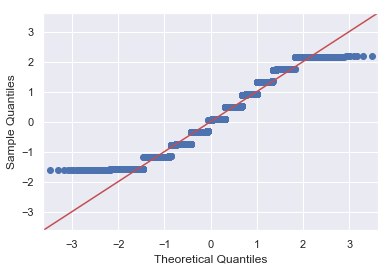

In [38]:
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

In [39]:
X = games1['Temp']
y = games1['Runs']

model = sm.discrete.count_model.ZeroInflatedNegativeBinomialP(X, y).fit()
predictions = model.predict(X)

AttributeError: module 'statsmodels.api' has no attribute 'discrete'

In [ ]:
w1_bootstrap = bootstrap(w1, 10000)
w1_bootstrap = np.mean(w1_bootstrap, axis=1)
w2_bootstrap = bootstrap(w2, 10000)
w2_bootstrap = np.mean(w2_bootstrap, axis=1)
w3_bootstrap = bootstrap(w3, 10000)
w3_bootstrap = np.mean(w3_bootstrap, axis=1)
#w_all_bootstrap = bootstrap(w_all, 10000)
#w_all_bootstrap = np.mean(w_all_bootstrap, axis=1)

differences1 = (w3_bootstrap - w1_bootstrap)
differences2 = (w3_bootstrap - w2_bootstrap)
differences3 = (w2_bootstrap - w1_bootstrap)

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.85, wspace=0.3)

lower_bound_w3 = np.percentile(w3_bootstrap, 2.5)
upper_bound_w3 = np.percentile(w3_bootstrap, 97.5)

ax1 = fig.add_subplot(3,1, 1)
ax1.set_xlabel('Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound_w3, color='r', label=round(lower_bound_w3,3))
ax1.axvline(upper_bound_w3, color='r', label=round(upper_bound_w3,3))
ax1.set_title('Bootstrapped Population: w3')
ax1_hist = ax1.hist(w3_bootstrap, bins=30)
ax1.legend()

lower_bound_w2 = np.percentile(w2_bootstrap, 2.5)
upper_bound_w2 = np.percentile(w2_bootstrap, 97.5)

ax2 = fig.add_subplot(3,1, 2)
ax2.set_xlabel('Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound_w2, color='r', label=round(lower_bound_w2,3))
ax2.axvline(upper_bound_w2, color='r', label=round(upper_bound_w2,3))
ax2.set_title('Bootstrapped Population: w2')
ax2_hist = ax2.hist(w2_bootstrap, bins=30)
ax2.legend()

lower_bound_w1 = np.percentile(w1_bootstrap, 2.5)
upper_bound_w1 = np.percentile(w1_bootstrap, 97.5)

ax3 = fig.add_subplot(3,1, 3)
ax3.set_xlabel('Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound_w1, color='r', label=round(lower_bound_w1,3))
ax3.axvline(upper_bound_w1, color='r', label=round(upper_bound_w1,3))
ax3.set_title('Bootstrapped Population: w1')
ax3_hist = ax3.hist(w1_bootstrap, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Temperature Categories')
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("w3", lower_bound_w3, upper_bound_w3))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("w2", lower_bound_w2, upper_bound_w2))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("w1", lower_bound_w1, upper_bound_w1))

In [ ]:
lower_bound1 = np.percentile(differences1, 2.5)
upper_bound1 = np.percentile(differences1, 97.5)
lower_bound2 = np.percentile(differences2, 2.5)
upper_bound2 = np.percentile(differences2, 97.5)
lower_bound3 = np.percentile(differences3, 2.5)
upper_bound3 = np.percentile(differences3, 97.5)

fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.6)

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('Difference in Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound1, color='r', label=round(lower_bound1,3))
ax1.axvline(upper_bound1, color='r', label=round(upper_bound1,3))
ax1.set_title('Bootstrapped Population (Difference Between w3, w1)')
ax1_hist = ax1.hist(differences1, bins=30)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('Difference in Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound2, color='r', label=round(lower_bound2,3))
ax2.axvline(upper_bound2, color='r', label=round(upper_bound2,3))
ax2.set_title('Bootstrapped Population (Difference Between w3, w2)')
ax2_hist = ax2.hist(differences2, bins=30)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('Difference in Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound3, color='r', label=round(lower_bound3,3))
ax3.axvline(upper_bound3, color='r', label=round(upper_bound3,3))
ax3.set_title('Bootstrapped Population (Difference Between w2, w1)')
ax3_hist = ax3.hist(differences3, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('w3', 'w1'))
print('Lower bound: {0:5.3f}'.format(lower_bound1))
print('Upper bound: {0:5.3f}'.format(upper_bound1))

p1 = differences1[differences1 <= 0].shape[0]
print("Number of samples where (mean) w1 > w3: {}\n".format(p1))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('w3', 'w2'))
print('Lower bound: {0:5.3f}'.format(lower_bound2))
print('Upper bound: {0:5.3f}'.format(upper_bound2))

p2 = differences2[differences2 <= 0].shape[0]
print("Number of samples where (mean) w2 > w3: {}\n".format(p2))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('w2', 'w1'))
print('Lower bound: {0:5.3f}'.format(lower_bound3))
print('Upper bound: {0:5.3f}'.format(upper_bound3))

p3 = differences3[differences3 <= 0].shape[0]
print("Number of samples where (mean) w1 > w2: {}".format(p3))

In [ ]:
combined = np.concatenate((w3, w2, w1), axis=0)

perms_w1 = []
perms_w2 = []
perms_w3 = []

for i in range(10000):
    np.random.seed(i)
    perms_w1.append(resample(combined, n_samples = len(w1)))
    perms_w2.append(resample(combined, n_samples = len(w2)))
    perms_w3.append(resample(combined, n_samples = len(w3)))
    
dif_bootstrap_means1 = (np.mean(perms_w3, axis=1)-np.mean(perms_w1, axis=1))
dif_bootstrap_means2 = (np.mean(perms_w3, axis=1)-np.mean(perms_w2, axis=1))
dif_bootstrap_means3 = (np.mean(perms_w2, axis=1)-np.mean(perms_w1, axis=1))

In [ ]:
obs_difs1 = np.mean(w3) - np.mean(w1)
obs_difs2 = np.mean(w3) - np.mean(w2)
obs_difs3 = np.mean(w2) - np.mean(w1)

p_value1 = dif_bootstrap_means1[dif_bootstrap_means1 >= obs_difs1].shape[0]/10000
p_value2 = dif_bootstrap_means2[dif_bootstrap_means2 >= obs_difs2].shape[0]/10000
p_value3 = dif_bootstrap_means3[dif_bootstrap_means3 >= obs_difs3].shape[0]/10000

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_xlabel('Difference in Runs (w3 - w1)')
ax1.set_ylabel('Frequency')
ax1.set_title('Bootstrapped Population (Combined data)')
ax1.axvline(obs_difs1, color='r')
d1 = ax1.hist(dif_bootstrap_means1, bins=30)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_xlabel('Difference in Runs (w3 - w2)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrapped Population (Combined data)')
ax2.axvline(obs_difs2, color='r')
d2 = ax2.hist(dif_bootstrap_means2, bins=30)

ax3 = fig.add_subplot(1,3, 3)
ax3.set_xlabel('Difference in Runs (w2 - w1)')
ax3.set_ylabel('Frequency')
ax3.set_title('Bootstrapped Population (Combined data)')
ax3.axvline(obs_difs3, color='r')
d3 = ax3.hist(dif_bootstrap_means3, bins=30)
plt.show()

print('observed difference in means: {0:5.4f} [w3,w1]'.format(obs_difs1))
print('observed difference in means: {0:5.4f} [w3,w2]'.format(obs_difs2))
print('observed difference in means: {0:5.4f} [w2,w1]'.format(obs_difs3))

print('p-value: {} [w3,w1]'.format(p_value1))
print('p-value: {} [w3,w2]'.format(p_value2))
print('p-value: {} [w2,w1]'.format(p_value3))

In [ ]:
anova = stats.f_oneway(w1, w2, w3)
print("anova p-value: {0:5.4f}".format(anova[1]))
print("anova z-value: {0:5.2f}\n".format(anova[0]))

rho, pval = stats.spearmanr(games3['Wind_Level1'], games3['Runs'])
print("spearman p-value: {0:4.3f}".format(pval))
print("spearman rho-value: {0:4.3f}\n".format(rho))

pt1 = pg.pairwise_tukey(dv='Runs', between='Wind_Level1', data=games3, tail='one-sided')
print(pt1)

There is a significant difference between runs scored with the wind blowing in and with the wind at less than 3mph.  However, the magnitude of the effect size is small as can be seen by the effect sizes.

## __Flyball Percentage__

H0: A pitchers flyball percentage does not effect the number of runs scored in a game

In [ ]:
f33 = 0.17 # np.percentile(games['FB%_Level'], 33, axis=0)
f66 = 0.3 # np.percentile(games['FB%_Level'], 66, axis=0)
f_cut = 0.0433
# Create data frame for games4 with temps between -10 and 10
games4 = games[(games['FB%_SIDE_pit'] >= 0.17) & (games['FB%_SIDE_pit'] < 0.3) & (games['Runs'] < 10)].copy()

f1 = games4['Runs'][(games4['FB%_SIDE_pit'] >= f33) & (games4['FB%_SIDE_pit'] < f33 + f_cut)]
f2 = games4['Runs'][(games4['FB%_SIDE_pit'] >= f33 + f_cut) & (games4['FB%_SIDE_pit'] < f66 - f_cut)]
f3 = games4['Runs'][(games4['FB%_SIDE_pit'] >= f66 - f_cut) & (games4['FB%_SIDE_pit'] < f66)]

games4['FB%_Level1'] = 0
games4.loc[games4['FB%_SIDE_pit'] < f33 + f_cut, 'FB%_Level1'] = 1
games4.loc[(games4['FB%_SIDE_pit'] >= f33 + f_cut) & (games4['FB%_SIDE_pit'] < f66 - f_cut), 'FB%_Level1'] = 2
games4.loc[games4['FB%_SIDE_pit'] >= f66 - f_cut, 'FB%_Level1'] = 3

In [ ]:
fig = plt.figure(figsize = (10,4))
title = fig.suptitle("Runs - FB%_Level", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_title("Flyball % > 24.5%")
ax1.set_xlabel("Runs")
ax1.set_ylabel("Frequency") 
ax1.set_ylim([0, 300])
ax1.text(5, 250, r'$mu$='+str(round(games4['Runs'][games4['FB%_Level1']==1].mean(),2)), 
         fontsize=12)
r_freq, r_bins, r_patches = ax1.hist(games4['Runs'][games4['FB%_Level1']==1], color='red', bins=10,
                                     edgecolor='black', linewidth=1)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_title("20.9% <= Flyball % <= 24.5%")
ax2.set_xlabel("Runs")
ax2.set_ylabel("Frequency")
ax2.set_ylim([0, 300])
ax2.text(5, 250, r'$mu$='+str(round(games4['Runs'][games4['FB%_Level1']==2].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax2.hist(games4['Runs'][games4['FB%_Level1']==2], color='white', bins=10,
                                     edgecolor='black', linewidth=1)


ax3 = fig.add_subplot(1,3, 3)
ax3.set_title("Flyball % > 3 MPH")
ax3.set_xlabel("Runs")
ax3.set_ylabel("Frequency")
ax3.set_ylim([0, 300])
ax3.text(5, 250, r'$mu$='+str(round(games4['Runs'][games4['FB%_Level1']==3].mean(),2)), 
         fontsize=12)
w_freq, w_bins, w_patches = ax3.hist(games4['Runs'][games4['FB%_Level1']==3], color='green', bins=10,
                                     edgecolor='black', linewidth=1)

In [ ]:
X = games4['FB%_SIDE_pit'] ## X usually means our input variables (or independent variables)
y = games4['Runs'] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

In [ ]:
f1_bootstrap = bootstrap(f1, 10000)
f1_bootstrap = np.mean(f1_bootstrap, axis=1)
f2_bootstrap = bootstrap(f2, 10000)
f2_bootstrap = np.mean(f2_bootstrap, axis=1)
f3_bootstrap = bootstrap(f3, 10000)
f3_bootstrap = np.mean(f3_bootstrap, axis=1)
#f_all_bootstrap = bootstrap(f_all, 10000)
#f_all_bootstrap = np.mean(f_all_bootstrap, axis=1)

differences1 = (f3_bootstrap - f1_bootstrap)
differences2 = (f3_bootstrap - f2_bootstrap)
differences3 = (f2_bootstrap - f1_bootstrap)

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.85, wspace=0.3)

lower_bound_f3 = np.percentile(f3_bootstrap, 2.5)
upper_bound_f3 = np.percentile(f3_bootstrap, 97.5)

ax1 = fig.add_subplot(3,1, 1)
ax1.set_xlabel('Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound_f3, color='r', label=round(lower_bound_f3,3))
ax1.axvline(upper_bound_f3, color='r', label=round(upper_bound_f3,3))
ax1.set_title('Bootstrapped Population: f3')
ax1_hist = ax1.hist(f3_bootstrap, bins=30)
ax1.legend()

lower_bound_f2 = np.percentile(f2_bootstrap, 2.5)
upper_bound_f2 = np.percentile(f2_bootstrap, 97.5)

ax2 = fig.add_subplot(3,1, 2)
ax2.set_xlabel('Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound_f2, color='r', label=round(lower_bound_f2,3))
ax2.axvline(upper_bound_f2, color='r', label=round(upper_bound_f2,3))
ax2.set_title('Bootstrapped Population: f2')
ax2_hist = ax2.hist(f2_bootstrap, bins=30)
ax2.legend()

lower_bound_f1 = np.percentile(f1_bootstrap, 2.5)
upper_bound_f1 = np.percentile(f1_bootstrap, 97.5)

ax3 = fig.add_subplot(3,1, 3)
ax3.set_xlabel('Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound_f1, color='r', label=round(lower_bound_f1,3))
ax3.axvline(upper_bound_f1, color='r', label=round(upper_bound_f1,3))
ax3.set_title('Bootstrapped Population: f1')
ax3_hist = ax3.hist(f1_bootstrap, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Temperature Categories')
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("f3", lower_bound_f3, upper_bound_f3))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("f2", lower_bound_f2, upper_bound_f2))
print('{0}:     Lower bound: {1:5.3f}     Upper bound: {2:5.3f}'.format("f1", lower_bound_f1, upper_bound_f1))

In [ ]:
lower_bound1 = np.percentile(differences1, 2.5)
upper_bound1 = np.percentile(differences1, 97.5)
lower_bound2 = np.percentile(differences2, 2.5)
upper_bound2 = np.percentile(differences2, 97.5)
lower_bound3 = np.percentile(differences3, 2.5)
upper_bound3 = np.percentile(differences3, 97.5)

fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(top=0.85, hspace=0.6)

ax1 = fig.add_subplot(3, 1, 1)
ax1.set_xlabel('Difference in Runs')
ax1.set_ylabel('Frequency')
ax1.axvline(lower_bound1, color='r', label=round(lower_bound1,3))
ax1.axvline(upper_bound1, color='r', label=round(upper_bound1,3))
ax1.set_title('Bootstrapped Population (Difference Between f3, f1)')
ax1_hist = ax1.hist(differences1, bins=30)
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)
ax2.set_xlabel('Difference in Runs')
ax2.set_ylabel('Frequency')
ax2.axvline(lower_bound2, color='r', label=round(lower_bound2,3))
ax2.axvline(upper_bound2, color='r', label=round(upper_bound2,3))
ax2.set_title('Bootstrapped Population (Difference Between f3, f2)')
ax2_hist = ax2.hist(differences2, bins=30)
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)
ax3.set_xlabel('Difference in Runs')
ax3.set_ylabel('Frequency')
ax3.axvline(lower_bound3, color='r', label=round(lower_bound3,3))
ax3.axvline(upper_bound3, color='r', label=round(upper_bound3,3))
ax3.set_title('Bootstrapped Population (Difference Between f2, f1)')
ax3_hist = ax3.hist(differences3, bins=30)
ax3.legend()
plt.show()

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('f3', 'f1'))
print('Lower bound: {0:5.3f}'.format(lower_bound1))
print('Upper bound: {0:5.3f}'.format(upper_bound1))

p1 = differences1[differences1 <= 0].shape[0]
print("Number of samples where (mean) f1 > f3: {}\n".format(p1))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('f3', 'f2'))
print('Lower bound: {0:5.3f}'.format(lower_bound2))
print('Upper bound: {0:5.3f}'.format(upper_bound2))

p2 = differences2[differences2 <= 0].shape[0]
print("Number of samples where (mean) f2 > f3: {}\n".format(p2))

print('95% Confidence Intervals for Mean Differce between {} & {}:'.format('f2', 'f1'))
print('Lower bound: {0:5.3f}'.format(lower_bound3))
print('Upper bound: {0:5.3f}'.format(upper_bound3))

p3 = differences3[differences3 <= 0].shape[0]
print("Number of samples where (mean) f1 > f2: {}".format(p3))

In [ ]:
combined = np.concatenate((f3, f2, f1), axis=0)

perms_f1 = []
perms_f2 = []
perms_f3 = []

for i in range(10000):
    np.random.seed(i)
    perms_f1.append(resample(combined, n_samples = len(f1)))
    perms_f2.append(resample(combined, n_samples = len(f2)))
    perms_f3.append(resample(combined, n_samples = len(f3)))
    
dif_bootstrap_means1 = (np.mean(perms_f3, axis=1)-np.mean(perms_f1, axis=1))
dif_bootstrap_means2 = (np.mean(perms_f3, axis=1)-np.mean(perms_f2, axis=1))
dif_bootstrap_means3 = (np.mean(perms_f2, axis=1)-np.mean(perms_f1, axis=1))

In [ ]:
obs_difs1 = np.mean(f3) - np.mean(f1)
obs_difs2 = np.mean(f3) - np.mean(f2)
obs_difs3 = np.mean(f2) - np.mean(f1)

p_value1 = dif_bootstrap_means1[dif_bootstrap_means1 >= obs_difs1].shape[0]/10000
p_value2 = dif_bootstrap_means2[dif_bootstrap_means2 >= obs_difs2].shape[0]/10000
p_value3 = dif_bootstrap_means3[dif_bootstrap_means3 >= obs_difs3].shape[0]/10000

fig = plt.figure(figsize=(12,4))
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,3, 1)
ax1.set_xlabel('Difference in Runs (f3 - f1)')
ax1.set_ylabel('Frequency')
ax1.set_title('Bootstrapped Population (Combined data)')
ax1.axvline(obs_difs1, color='r')
d1 = ax1.hist(dif_bootstrap_means1, bins=30)

ax2 = fig.add_subplot(1,3, 2)
ax2.set_xlabel('Difference in Runs (f3 - f2)')
ax2.set_ylabel('Frequency')
ax2.set_title('Bootstrapped Population (Combined data)')
ax2.axvline(obs_difs2, color='r')
d2 = ax2.hist(dif_bootstrap_means2, bins=30)

ax3 = fig.add_subplot(1,3, 3)
ax3.set_xlabel('Difference in Runs (f2 - f1)')
ax3.set_ylabel('Frequency')
ax3.set_title('Bootstrapped Population (Combined data)')
ax3.axvline(obs_difs3, color='r')
d3 = ax3.hist(dif_bootstrap_means3, bins=30)
plt.show()

print('observed difference in means: {0:5.4f} [f3,f1]'.format(obs_difs1))
print('observed difference in means: {0:5.4f} [f3,f2]'.format(obs_difs2))
print('observed difference in means: {0:5.4f} [f2,f1]'.format(obs_difs3))

print('p-value: {} [f3,f1]'.format(p_value1))
print('p-value: {} [f3,f2]'.format(p_value2))
print('p-value: {} [f2,f1]'.format(p_value3))

In [ ]:
anova = stats.f_oneway(f1, f2, f3)
print("anova p-value: {0:5.4f}".format(anova[1]))
print("anova z-value: {0:5.2f}\n".format(anova[0]))

kruskal = stats.kruskal(f1, f2, f3, equal_var = False)
print("Kruskal p-value: {0:7.5f}".format(kruskal[1]))
print("Kruskal z-value: {0:5.2f}\n".format(kruskal[0]))

rho, pval = stats.spearmanr(games4['FB%_Level1'], games4['Runs'])
print("spearman p-value: {0:4.3f}".format(pval))
print("spearman rho-value: {0:4.3f}\n".format(rho))

pt1 = pg.pairwise_tukey(dv='Runs', between='FB%_Level1', data=games4, tail='one-sided')
print(pt1)

The p-values are well below 0.05 and H0 is rejected.  The effect sizes of 0.112 and 0.098 are small.

In [ ]:
sns.set()
f, ax = plt.subplots(figsize=(14, 5))
sns.pointplot('FB%_SIDE_pit', 'Runs', data=games4)
sns.despine(bottom=True)
plt.show()

In [ ]:
import pylab 
stats.probplot(games2['Runs'], dist="norm", plot=pylab)
pylab.show()

In [ ]:
sm.qqplot(games2['Runs'], fit=True, line='45')
pylab.show()

In [ ]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

r = np.mean(games['Runs'])**2/(np.var(games['Runs']) - np.mean(games['Runs']))
p = (np.var(games['Runs']) - np.mean(games['Runs'])) / np.var(games['Runs'])

from scipy.stats import nbinom
data_nbinom = nbinom.rvs(r, p, size=10000)

convert_params(np.mean(games['Runs']), r)

sns.distplot(data_nbinom, kernel='gau')

In [ ]:
sns.kdeplot(data_nbinom, kernel='gau', bw=.5)
sns.kdeplot(games['Runs'])